## Import Libraries

In [ ]:
import numpy as np
from skimage.feature import hog , local_binary_pattern
import glob
from matplotlib import image as mpimg
import cv2
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from skimage.color import rgb2gray, rgba2rgb
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix , roc_curve, auc
import os
from PIL import Image
from tqdm import tqdm
from skimage import filters
import pickle
import math
from mtcnn import MTCNN
from sklearn.model_selection import GridSearchCV
import seaborn as sns
# from retinaface import RetinaFace

### Initialization

In [ ]:
emotions = ['confident' , 'unconfident']
emotions_feature_vector = {emotion : [] for emotion in emotions}
training_dataset_labels = []
detector = MTCNN()

## Read Images

In [ ]:
def read_images(path):
    images = []
    for img in glob.glob(f'{path}/*.[pj][np]g'):
        image = cv2.cvtColor(cv2.imread(img) , cv2.COLOR_BGR2RGB)
        images.append(image)
    return images

## Show Image

In [ ]:
def show_image(img , title , gray):
    if gray:
        plt.imshow(img , cmap = 'gray')
    else:
        plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()

## Face Extraction

In [ ]:
def detect_face(image):
    # Convert the image to YCbCr color space
    ycbcr = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
    y, cr, cb = cv2.split(ycbcr)

    # Define thresholds for skin detection in the Cr channel
    cr1 = cv2.GaussianBlur(cr, (5, 5), 0)
    _, skin = cv2.threshold(cr1, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Apply morphological operations to clean up the binary image
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    skin = cv2.morphologyEx(skin, cv2.MORPH_CLOSE, kernel, iterations=2)
    skin = cv2.morphologyEx(skin, cv2.MORPH_OPEN, kernel, iterations=2)

    # Find contours in the binary image
    contours, _ = cv2.findContours(skin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        return None

    # Find the largest contour
    largest_contour = max(contours, key=cv2.contourArea)

    # Get the bounding box of the largest contour
    x, y, w, h = cv2.boundingRect(largest_contour)

    return (x, y, w, h)

## Testing Face extraction

In [ ]:
# Load the image
image = cv2.imread('/content/images7/sampled_frames/frame_1020.jpg')

# Detect the face in the image
face = detect_face(image)

# Draw a rectangle around the detected face if found
if face is not None:
    x, y, w, h = face
    cv2.rectangle(image, (x, y), (x+w, y+h), (255, 0, 0), 2)

    # Extract the detected face region
    face_region = image[y:y+h, x:x+w]

    # Save the extracted face as a new image
    cv2.imwrite('detected_face.jpg', face_region)

# Display the result
show_image(image, "Before detection" , True)
show_image(image , 'Detected Face', False)
cv2.waitKey(0)
cv2.destroyAllWindows()

## HOG Implementation

In [ ]:
import numpy as np
import cv2
from skimage import color
import matplotlib.pyplot as plt
from skimage.draw import line

def compute_gradients(image):
    gx = np.zeros_like(image, dtype=np.float32)
    gy = np.zeros_like(image, dtype=np.float32)
    gx[:, :-1] = np.diff(image, n=1, axis=1)
    gy[:-1, :] = np.diff(image, n=1, axis=0)
    return gx, gy

def gradient_magnitude_orientation(gx, gy):
    magnitude = np.sqrt(gx**2 + gy**2)
    orientation = np.arctan2(gy, gx) * (180 / np.pi) % 180
    return magnitude, orientation

def get_cell_histograms(magnitude, orientation, cell_size):
    cells_x = magnitude.shape[1] // cell_size[1]
    cells_y = magnitude.shape[0] // cell_size[0]
    hist_bins = 18  # Number of bins
    hist_range = 180
    hist_per_cell = np.zeros((cells_y, cells_x, hist_bins))

    for i in range(cells_y):
        for j in range(cells_x):
            cell_magnitude = magnitude[i*cell_size[0]:(i+1)*cell_size[0], j*cell_size[1]:(j+1)*cell_size[1]]
            cell_orientation = orientation[i*cell_size[0]:(i+1)*cell_size[0], j*cell_size[1]:(j+1)*cell_size[1]]
            hist, _ = np.histogram(cell_orientation, bins=hist_bins, range=(0, hist_range), weights=cell_magnitude)
            hist_per_cell[i, j, :] = hist
    return hist_per_cell

def normalize_blocks(hist_per_cell, block_size):
    blocks_y = hist_per_cell.shape[0] - block_size[0] + 1
    blocks_x = hist_per_cell.shape[1] - block_size[1] + 1
    normalized_blocks = np.zeros((blocks_y, blocks_x, block_size[0], block_size[1], hist_per_cell.shape[2]))

    for i in range(blocks_y):
        for j in range(blocks_x):
            block = hist_per_cell[i:i+block_size[0], j:j+block_size[1], :]
            normalized_block = block / np.sqrt(np.sum(block**2) + 1e-5)
            normalized_blocks[i, j, :] = normalized_block
    return normalized_blocks

def HOG_Features(image, pixels_per_cell, cells_per_block):
    if len(image.shape) == 3:
        image = color.rgb2gray(image)

    gx, gy = compute_gradients(image)
    magnitude, orientation = gradient_magnitude_orientation(gx, gy)
    cell_size = pixels_per_cell
    hist_per_cell = get_cell_histograms(magnitude, orientation, cell_size)
    block_size = cells_per_block
    normalized_blocks = normalize_blocks(hist_per_cell, block_size)
    hog_features = normalized_blocks.ravel()
    return hog_features, magnitude, orientation

def visualize_hog(image, magnitude, orientation, cell_size):
    hog_image = np.zeros_like(image, dtype=np.float32)
    cell_width = cell_size[0]
    max_hist_value = np.max(magnitude)

    for i in range(0, image.shape[0], cell_width):
        for j in range(0, image.shape[1], cell_width):
            cell_magnitude = magnitude[i:i + cell_width, j:j + cell_width]
            cell_orientation = orientation[i:i + cell_width, j:j + cell_width]
            hist, _ = np.histogram(cell_orientation, bins=18, range=(0, 180), weights=cell_magnitude)  # Match bins here

            for bin_idx in range(18):
                angle = bin_idx * 10  # Adjust angle increment
                radians = np.deg2rad(angle)
                center_x = j + cell_width // 2
                center_y = i + cell_width // 2
                dx = int(np.cos(radians) * hist[bin_idx] * 10 / max_hist_value)
                dy = int(np.sin(radians) * hist[bin_idx] * 10 / max_hist_value)
                rr, cc = line(center_y, center_x, center_y + dy, center_x + dx)
                rr = np.clip(rr, 0, hog_image.shape[0] - 1)
                cc = np.clip(cc, 0, hog_image.shape[1] - 1)
                hog_image[rr, cc] += hist[bin_idx] * 2  # Scale to enhance visibility

    # Apply Gaussian smoothing
    hog_image = cv2.GaussianBlur(hog_image, (5, 5), 1)

    return hog_image

pixels_per_cell = (4, 4)  # Adjusted cell size
cells_per_block = (4, 4)  # Adjusted block size

### Image Preprocessing

In [ ]:
def normalized_img(img):
    normalized_image = img.astype(np.float32) / 255.0
    return normalized_image
def aligned_img(img , img_path):
    localization = RetinaFace.detect_faces(img_path = "/kaggle/input/data-mix/datamixed/train/confident/000ad778e32e1c44f2ec87c991390e24e504de01d710fe9081aa0e75.jpg")
    if localization.keys():
        x1 , y1 = localization['face_1']['landmarks']['right_eye']
        x2 , y2 = localization['face_1']['landmarks']['left_eye']
        a = abs(y1 - y2)
        b = abs(x2 - x1)
        c = math.sqrt(a * a + b * b)
        cosine_alpha = (b*b + c*c - a*a) / (2*b*c)
        alpha = np.arccos(cosine_alpha)
        alpha = (alpha * 180) / math.pi
        aligned_image = Image.fromarray(img)
        aligned_image = np.array(aligned_image.rotate(alpha))
        return aligned_image
    else:
        return []
def HistogramEqualization(image,nbins=256):
    image = np.uint8(image*255)
    H = np.zeros(nbins)

    m, n = image.shape

    H = np.histogram(image, 256, [0,255])
    H_c = np.cumsum(H[0])

    q = 255*np.array(H_c)/(m*n)

    edited_image = np.zeros(image.shape)

    edited_image[:, :] = q[image[:, :]]
    return edited_image

def calculate_histogram(img):
    hist, bins = np.histogram(img.flatten(), 256, [0, 256])
    return hist

def is_image_dark(hist):
    if np.sum(hist[:128]) > np.sum(hist[128:]):
        return True  # Image is considered dark
    else:
        return False  # Image is considered bright

def apply_gamma_correction(img, c, is_dark):
    if is_dark:
        print("dark")
        gamma = 0.5  # Brighten dark images
    else:
        print("bright")
        gamma = 3    # Darken bright images
    edited_img = c * (img**gamma)
    return edited_img

def Gamma_Correction(img, c):
    hist = calculate_histogram(img)
    is_dark = is_image_dark(hist)
    gray = rgb2gray(img)
    edited_img = apply_gamma_correction(gray, c, is_dark)
    return edited_img

    return equalized_image
def image_preprocessing(img):
    detected_face = detector.detect_faces(img)
    if len(detected_face):
        x , y , width , height = detected_face[0]['box']
        face = img[y : y + height , x : x + width]
    else:
        return []
    gray_img = None
    if len(face):
        gamma_corrected_img = Gamma_Correction(face , 10)
        normalizedImage = normalized_img(gamma_corrected_img)
        resized_img = cv2.resize(normalizedImage, (128, 128))
        return resized_img
    else:
        return []

### Preparing dataset

In [ ]:
processed_images, ignored_images = 0 , 0
for emotion in emotions:
    emotions_folder = f'/content/Filtered_dataset/train/{emotion}/'
    for emotion_img in glob.glob(f'{emotions_folder}*.[pj][np]g'):
        img = cv2.cvtColor(cv2.imread(emotion_img) , cv2.COLOR_BGR2RGB)
        processed_image = image_preprocessing(img)
        if len(processed_image):
            feature_vector, _, _ = HOG_Features(processed_image, pixels_per_cell , cells_per_block)
            emotions_feature_vector[emotion].append(feature_vector)
            training_dataset_labels.append(emotion)
            print(f"Image {processed_images + 1} processed!")
            processed_images += 1
        else:
            print(f"Ignored {ignored_images + 1} Images!")
            ignored_images += 1
            continue
training_dataset = [feature for emotions_list in emotions_feature_vector.values() for feature in emotions_list]
print(len(training_dataset) , len(training_dataset_labels))

1/1 [==============================] - 0s 208ms/step


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 30ms/step
bright
Image 581 processed!
1/1 [==============================] - 0s 29ms/step
bright
Image 582 processed!
1/1 [==============================] - 0s 28ms/step
bright
Image 583 processed!
1/1 [==============================] - 0s 35ms/step
bright
Image 584 processed!
1/1 [==============================] - 0s 29ms/step
bright
Image 585 processed!
1/1 [==============================] - 0s 30ms/step
bright
Image 586 processed!
1/1 [==============================] - 0s 74ms/step
bright
Image 587 processed!
1/1 [==============================] - 0s 43ms/step
bright
Image 588 processed!
1/1 [==============================] - 0s 35ms/step
bright
Image 589 processed!
1/1 [==============================] - 0s 31ms/step
bright
Image 590 processed!
1/1 [==============================] - 0s 30ms/step
bright
Image 591 processed!
1/1 [==============================] - 0s 28ms/step
bright
Image 592 

### Preparing Testset

In [ ]:
test_features, test_labels = [], []
processed_images, ignored_images = 0 , 0
for emotion in emotions:
    emotions_folder = f'/content/Filtered_dataset/test/{emotion}/'
    for emotion_img in glob.glob(f'{emotions_folder}*.[pj][np]g'):
        img = cv2.cvtColor(cv2.imread(emotion_img) , cv2.COLOR_BGR2RGB)
        processed_image = image_preprocessing(img)
        if len(processed_image):
            feature_vector , _ , _ = HOG_Features(processed_image , cells_per_block, pixels_per_cell)
            test_features.append(feature_vector)
            test_labels.append(emotion)
            print(f"Image {processed_images + 1} processed!")
            processed_images += 1
        else:
            print(f"Ignored {ignored_images + 1} Images!")
            ignored_images += 1
            continue

1/1 [==============================] - 0s 54ms/step
dark
Image 1 processed!
1/1 [==============================] - 0s 47ms/step
bright
Image 2 processed!
1/1 [==============================] - 0s 30ms/step
dark
Image 3 processed!
1/1 [==============================] - 0s 29ms/step
dark
Image 4 processed!
1/1 [==============================] - 0s 32ms/step
bright
Image 5 processed!
1/1 [==============================] - 0s 28ms/step
bright
Image 6 processed!
1/1 [==============================] - 0s 44ms/step
bright
Image 7 processed!
1/1 [==============================] - 0s 48ms/step
Ignored 1 Images!
1/1 [==============================] - 0s 55ms/step
bright
Image 8 processed!
1/1 [==============================] - 0s 28ms/step
bright
Image 9 processed!
1/1 [==============================] - 0s 29ms/step
bright
Image 10 processed!
1/1 [==============================] - 0s 34ms/step
dark
Image 11 processed!
1/1 [==============================] - 0s 31ms/step
bright
Image 12 processed!

## Find best hyperparameters

In [ ]:
param_grid = {

    'C': [0.1, 1, 10],
    'gamma': [1, 0.1, 0.01],
    'kernel': ['sigmoid', 'rbf']
}

# Create a GridSearchCV object
grid = GridSearchCV(SVC(probability=True), param_grid, refit=True, verbose=2, cv = 3)

# Fit the grid search to the data
grid.fit(training_dataset, training_dataset_labels)

# Print the best parameters and estimator
print("Best Parameters:")
print(grid.best_params_)
print("Best Estimator:")
print(grid.best_estimator_)


Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time= 4.0min
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time= 4.0min
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time= 3.9min
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time= 4.8min
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time= 4.9min
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time= 4.9min
[CV] END ...................C=0.1, gamma=0.1, kernel=sigmoid; total time= 3.9min
[CV] END ...................C=0.1, gamma=0.1, kernel=sigmoid; total time= 3.9min
[CV] END ...................C=0.1, gamma=0.1, kernel=sigmoid; total time= 3.9min
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time= 4.8min
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time= 4.7min
[CV] END .......................C=0.1, gamma=0.1

## Training SVM

In [ ]:
svm = SVC(kernel = "rbf" , random_state = 0)
svm.fit(training_dataset , training_dataset_labels)

SVC(random_state=0)

## Visualizing Results

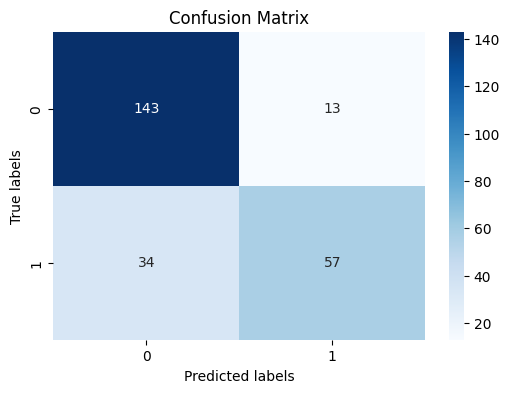

In [ ]:
def visualize_confusion_matrix(confusion_matrix):
  plt.figure(figsize=(6, 4))
  sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g')
  plt.xlabel('Predicted labels')
  plt.ylabel('True labels')
  plt.title('Confusion Matrix')
  plt.show()
predicted_labels = svm.predict(test_features)
conf_matrix = confusion_matrix(test_labels , predicted_labels)
visualize_confusion_matrix(conf_matrix)

## Model Evaluation

In [ ]:
accuracy = svm.score(test_features, test_labels)
print(accuracy)

0.8097165991902834


## Save Model in Pickle format

In [ ]:
def save_model(model , filename):
    with open(filename, 'wb') as file:
        pickle.dump(model, file)
save_model(svm , "/content/model_v3.pkl")

## Load Model

In [ ]:
def load_model(filename):
    with open(filename, 'rb') as file:
        model = pickle.load(file)
    return model
svm = load_model("/kaggle/input/model-v1/model_v1.pkl")

## Read Video and Take sample

In [ ]:
def is_significant_motion(previous_frame, current_frame, threshold=5.0):
    gray_prev = cv2.cvtColor(previous_frame, cv2.COLOR_BGR2GRAY)
    gray_curr = cv2.cvtColor(current_frame, cv2.COLOR_BGR2GRAY)
    frame_diff = cv2.absdiff(gray_prev, gray_curr)
    _, thresh = cv2.threshold(frame_diff, 25, 255, cv2.THRESH_BINARY)
    motion_area = (cv2.countNonZero(thresh) / gray_curr.size) * 100
    return motion_area > threshold

def sample_and_select_frames(video_path, output_dir, sampling_rate=1):
    sampled_frames_dir = os.path.join(output_dir, "sampled_frames")
    selected_frames_dir = os.path.join(output_dir, "selected_frames")
    os.makedirs(sampled_frames_dir, exist_ok=True)
    os.makedirs(selected_frames_dir, exist_ok=True)

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error opening video file.")
        return

    fps = int(cap.get(cv2.CAP_PROP_FPS))
    frame_count = 0
    selected_frame_count = 0

    ret, prev_frame = cap.read()
    while ret:
        if frame_count % (fps // sampling_rate) == 0:
            frame_path = os.path.join(sampled_frames_dir, f"frame_{frame_count}.jpg")
            cv2.imwrite(frame_path, prev_frame)
            ret, current_frame = cap.read()
            if ret and is_significant_motion(prev_frame, current_frame, threshold=5.0):
                selected_frame_path = os.path.join(selected_frames_dir, f"selected_frame_{frame_count}.jpg")
                cv2.imwrite(selected_frame_path, current_frame)
                selected_frame_count += 1
            prev_frame = current_frame if ret else prev_frame
        frame_count += 1
        ret, _ = cap.read()
    cap.release()
    print(f"Total sampled frames: {frame_count // (fps // sampling_rate)}")
    print(f"Total selected frames: {selected_frame_count}")

video_path = '/content/test_vedio.mp4'
output_dir = '/content/images11'
sample_and_select_frames(video_path, output_dir, sampling_rate = 2)

Total sampled frames: 104
Total selected frames: 92


## Prediction

In [ ]:
def single_prediction():
    images = read_images("/content/images11/sampled_frames")
    total_samples = 0
    total_samples , confident_sample , unconfident_sample = len(images) , 0 , 0
    for image in images:
        show_image(image, "Test", False)
        processed_image = image_preprocessing(image)
        if len(processed_image) != 0:
            feature_vector, _ , _ = HOG_Features(processed_image , pixels_per_cell , cells_per_block)
            predicted_value = svm.predict([feature_vector])
            print(predicted_value[0])
            if predicted_value[0] == 'confident':
                confident_sample += 1
            else:
                unconfident_sample += 1
        else:
            total_samples -= 1
    return (confident_sample  , unconfident_sample, total_samples)
result = single_prediction()
print(result)

In [ ]:
confident_precentage = (result[0] / result[2]) * 100
unconfident_precentage = (result[1] / result[2]) * 100
print("Person is confident with " , confident_precentage,"%")
print("Preson is unconfident with " , unconfident_precentage,"%")

Person is confident with  23.809523809523807 %
Preson is unconfident with  76.19047619047619 %


1/1 [==============================] - 0s 49ms/step
bright


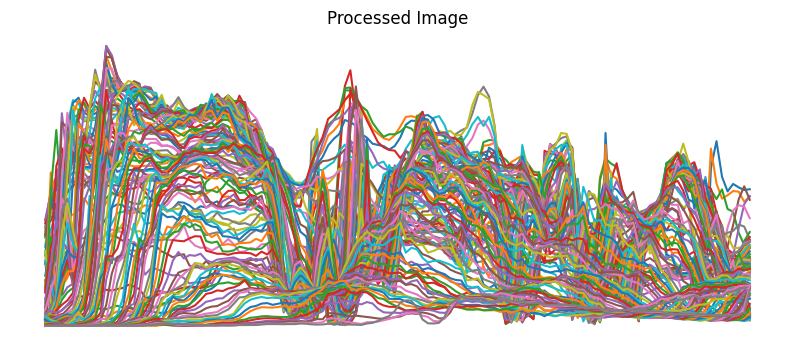

TypeError: hog() got an unexpected keyword argument 'visualize'

In [ ]:
img = cv2.cvtColor(cv2.imread("/content/Filtered_dataset/train/confident/000be90a828409ffe480ba9b3b8bab5fcad49c341a535dacb289d849.jpg"),cv2.COLOR_BGR2RGB)
processedImage = image_preprocessing(img)
show_image(processedImage , "Processed Image" , True)
# show_image(img, "Original Image", True)
feature_vector, feature_img = hog(processedImage, visualize = True , pixels_per_cell = (4 , 4) , cells_per_block = (4 , 4))
predicted = svm.predict([feature_vector])
print(predicted)
show_image(feature_img , "HOG Extracted features Image" , True)

1/1 [==============================] - 0s 55ms/step
bright


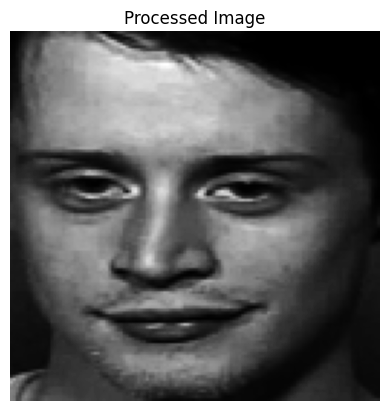

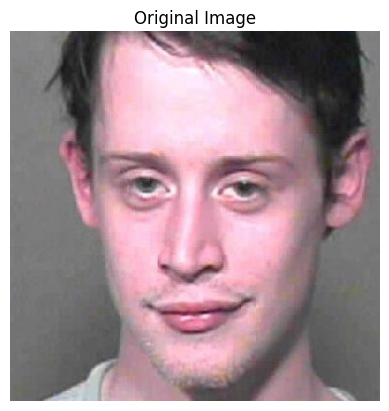

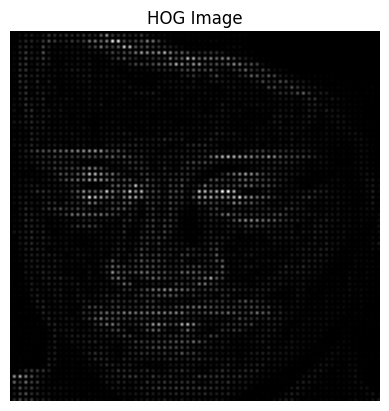

In [ ]:
from skimage.color import rgb2gray
from skimage.feature import hog
import cv2
import matplotlib.pyplot as plt

def show_image(image, title, cmap_type='gray'):
    plt.imshow(image, cmap=cmap_type)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Assuming image_preprocessing is defined elsewhere
# img = cv2.cvtColor(cv2.imread("/path/to/image.jpg"), cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(cv2.imread("/content/Filtered_dataset/train/confident/000be90a828409ffe480ba9b3b8bab5fcad49c341a535dacb289d849.jpg"), cv2.COLOR_BGR2RGB)
gray = rgb2gray(img)
corrected = image_preprocessing(img)

# Using the correct argument name 'visualise'
feature_vector, feature_img = hog(corrected, visualize=True, pixels_per_cell=(2, 2), cells_per_block=(2, 2))

show_image(corrected, "Processed Image", 'gray')
show_image(img, "Original Image", 'gray')
show_image(feature_img, "HOG Image", 'gray')


1/1 [==============================] - 0s 58ms/step


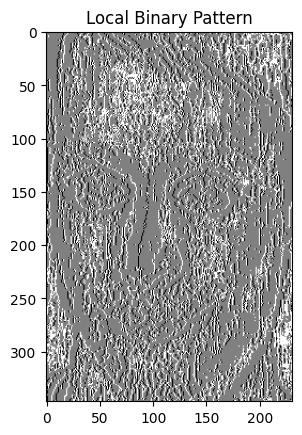

In [ ]:
from skimage.feature import local_binary_pattern
import matplotlib.pyplot as plt
img = cv2.cvtColor(cv2.imread("/content/Filtered_dataset/train/confident/000be90a828409ffe480ba9b3b8bab5fcad49c341a535dacb289d849.jpg"), cv2.COLOR_BGR2RGB)
detected_face = detector.detect_faces(img)
if len(detected_face):
    x , y , width , height = detected_face[0]['box']
    face = img[y : y + height , x : x + width]
image = rgb2gray(face)
# Define parameters for LBP
radius = 1
n_points = 2 * radius
METHOD = 'uniform'

# Compute LBP
lbp = local_binary_pattern(image, n_points, radius, METHOD)

# Visualize the LBP image
plt.imshow(lbp, cmap='gray')
plt.title('Local Binary Pattern')
plt.show()
